# Generate Training Data
## Preparation

In [ ]:
from scapy.all import *
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import glob

In [2]:
import logging

logging.basicConfig(level=logging.DEBUG)
logging.getLogger('matplotlib').setLevel(logging.WARNING)

In [3]:
# select data
c_logs = glob.glob('../traffic/20210920-lab/tcpdump_lab*.pcap')
s_logs = glob.glob('../traffic/20210920-lab/eth*.pcap')

c_logs, s_logs

(['../traffic/20210920-lab/tcpdump_labdebug_bind9113_0x49_vpn0_20210920150444.pcap',
  '../traffic/20210920-lab/tcpdump_labdebug_powerdns460_0x17_vpn0_20210920150444.pcap',
  '../traffic/20210920-lab/tcpdump_labdebug_kresd532_0x2c_vpn0_20210920150444.pcap',
  '../traffic/20210920-lab/tcpdump_labdebug_ws2012r2_0x6_vpn0_20210920150444.pcap',
  '../traffic/20210920-lab/tcpdump_labdebug_ws2019_0x14_vpn0_20210920150444.pcap',
  '../traffic/20210920-lab/tcpdump_labdebug_ws2012_0x29_vpn0_20210920150444.pcap',
  '../traffic/20210920-lab/tcpdump_labdebug_unbound167_0x4d_vpn0_20210920150444.pcap',
  '../traffic/20210920-lab/tcpdump_labdebug_ws2016_0x0_vpn0_20210920150444.pcap'],
 ['../traffic/20210920-lab/eth0-20210920093751.pcap',
  '../traffic/20210920-lab/eth3-20210920093751.pcap',
  '../traffic/20210920-lab/eth1-20210920093751.pcap',
  '../traffic/20210920-lab/eth2-20210920093751.pcap'])

In [4]:
# Formatters for displaying pandas data tables with columns of (lists of) scapy packets

def packet_list_fmt(lst):
    return f"{len(lst)} packets"

def packet_fmt(pkt):
    return pkt[DNS].summary()

In [5]:
ALGO_NAME = {
    0: 'unsigned',
    0: 0,
    5: 'rsasha1', 
    7: 'rsasha1nsec3sha1', 
    8: 'rsasha256', 
    10: 'rsasha512',
    13: 'ecdsap256sha256', 
    14: 'ecdsap384sha384', 
    15: 'ed25519', 
    16: 'ed448',
}
ALGO_NUM = {name: num for num, name in ALGO_NAME.items()}

In [6]:
# retrieve information encoded in DNS qnames

def split_qname(row):
    qname = row['qname']
    parts = qname.decode('ascii').split(".")
    try:
        if ".".join(parts[-3:]) == "dnstb.net.":
            # identify the "main" label that contians the cipher, keysize, nsec, and validity information
            for idx, p in enumerate(parts):
                if '-' in p or p == 'unsigned':
                    main_label = p
                    main_label_idx = idx
                    break
            else:
                raise IndexError

            # identify any query label at the leaf of the qname
            low_label = '.'.join(parts[0:main_label_idx])

            # identify any query label right below dnstb.net.
            high_label = '.'.join(parts[main_label_idx+1:-3])

            if main_label == 'unsigned':
                return {
                    'zone_algorithm': 0,
                    'zone_keysize': 0,
                    'zone_nsec': 0,
                    'zone_status': 'unsigned',
                    'low_label': low_label,
                    'high_label': high_label,                    
                }
            else:
                zone_algorithm, zone_keysize, zone_nsec, zone_status = main_label.split('-')            
                return {
                    'zone_algorithm': zone_algorithm,
                    'zone_keysize': zone_keysize,
                    'zone_nsec': zone_nsec,
                    'zone_status': zone_status,
                    'low_label': low_label,
                    'high_label': high_label,                    
                }
    except IndexError:
        logging.warning(f"could not split qname {qname} into meaningful information")
    return {
        'zone_algorithm': None,
        'zone_keysize': None,
        'zone_nsec': None,
        'zone_status': None,
        'low_label': None,
        'high_label': None,
    }

## Load Data

In [7]:
# load the traffic logs

c_packets = reduce(lambda a,b: a + b, (rdpcap(f) for f in tqdm(c_logs)))

In [8]:
s_packets = reduce(lambda a,b: a + b, (rdpcap(f) for f in tqdm(s_logs)))
s_packets = sorted(s_packets, key=lambda p: p.time)

In [9]:
# using the client logs, get a list of queries

queries = []
queries_by_id = {}
dropped = []

for p in tqdm(c_packets):
    try:
        p[DNS]
    except IndexError:
        # ignore error if p is TCP packet
        # TODO find better way to ignore TCP acks
        try:
            p[TCP]
        except IndexError:
            logging.warning(f'Broken DNS packet at time {p.time}?')
            dropped.append(p)
        continue
    if p[DNS].qr == 0:
        # query
        qid = p[DNS].id
        q = {
            'id': qid,
            'qname': p[DNS].qd.qname.lower(),
            'tag': p[DNS].qd.qname.split(b'.', 1)[0].lower(),
            'started': p.time,
            'client_packets': [p],
            'client_query': p,
            'client_response': None,
            'server_packets': [],
        }
        queries.append(q)
        queries_by_id[qid] = q
    else:
        # response
        qid = p[DNS].id
        try:
            queries_by_id[qid]
        except KeyError:
            logging.warning(f"Response without query at time {p.time}")
            continue
        queries_by_id[qid]['finished'] = p.time
        queries_by_id[qid]['client_packets'].append(p)
        queries_by_id[qid]['client_response'] = p
    
queries = pd.DataFrame(queries)
queries['qname_parts'] = queries.apply(split_qname, axis=1)
for key in ['zone_algorithm', 'zone_keysize', 'zone_nsec', 'zone_status', 'low_label', 'high_label']:
    queries[key] = queries.apply(lambda row: row['qname_parts'][key], axis=1)
del queries['qname_parts']

first_query_time, last_query_time = queries['started'].min(), queries['finished'].max()

In [10]:
len(queries), len(dropped)

(362, 6)

In [11]:
queries['low_label'].unique(), queries['zone_algorithm'].unique()

(array([None, 'labdebugibind9113i20210920150444',
        'labdebugipowerdns460i20210920150444',
        'labdebugikresd532i20210920150444',
        'labdebugiws2012r2i20210920150444',
        'labdebugiws2019i20210920150444', 'labdebugiws2012i20210920150444',
        'labdebugiunbound167i20210920150444',
        'labdebugiws2016i20210920150444'], dtype=object),
 array([None, 'ecdsap256sha256', 'ecdsap384sha384', 'ed25519', 'ed448',
        'rsasha1', 'rsasha1nsec3sha1', 'rsasha256', 'rsasha512', 0],
       dtype=object))

In [12]:
set(queries[queries['low_label'].isna() | queries['zone_algorithm'].isna() | queries['zone_keysize'].isna()]['qname'])

{b'dnssec-failed.org.', b'ns.x.dnsstu.de.', b'qnamemintest.internet.nl.'}

In [13]:
len(s_packets)

5191

## Match Client and Server Data

In [14]:
queries['started'] = queries['started'].astype(np.float64)
queries['finished'] = queries['finished'].astype(np.float64)

In [15]:
queries = queries.sort_values('started')
queries = queries.reset_index()

In [16]:
pd.options.display.precision = 16

In [17]:
offset = queries['started'].min()

In [18]:
queries['started'] -= offset
queries['finished'] -= offset

In [19]:
queries[['started', 'finished', 'qname', 'zone_algorithm']]

,started,finished,qname,zone_algorithm
0,0.0000000000000000,0.0149691104888916,b'ns.x.dnsstu.de.',None
1,0.0263991355895996,3.6908221244812012,b'qnamemintest.internet.nl.',None
2,3.7133522033691406,3.9489231109619141,b'dnssec-failed.org.',None
3,3.9637591838836670,3.9699871540069580,b'dnssec-failed.org.',None
4,4.0094180107116699,4.0833001136779785,b'labdebugiws2012i20210920150444.ecdsap256sha2...,ecdsap256sha256
...,...,...,...,...
357,343.2532021999359131,343.4869601726531982,b'labdebugiunbound167i20210920150444.rsasha512...,rsasha512
358,343.4875650405883789,343.5696330070495605,b'labdebugiunbound167i20210920150444.rsasha512...,rsasha512
359,343.5703091621398926,343.8345720767974854,b'labdebugiunbound167i20210920150444.rsasha512...,rsasha512
360,343.8351671695709229,344.0228641033172607,b'labdebugiunbound167i20210920150444.rsasha512...,rsasha512


In [20]:
i_q_front = 0
i_q_back = 0
duration = (queries['finished'] - queries['started']).max()
clock_accuracy = .1
ptime = float('-inf')

for p in tqdm(s_packets):
    assert float(p.time) - offset >= ptime, f's_packets not sorted by time: previous: {ptime} next: {float(p.time) - offset}'
    ptime = float(p.time) - offset
    #logging.warning(f"Packet time {ptime}")
    
    if ptime < 0:
        continue
    
    # query candidates for a given server packet with time ptime must have started < ptime
    
    # move the back pointer to the first paket that has started >= ptime
    # result: everything after back is irrelevant for this server paket
    while i_q_back + 1 < len(queries) and queries.iloc[i_q_back + 1]['started'] < ptime + clock_accuracy:
        i_q_back += 1
        
    # move the front pointer to the last paket that has started + duration <= ptime
    while i_q_front < len(queries) and queries.iloc[i_q_front]['started'] < ptime - duration - clock_accuracy:
        i_q_front += 1
    
    #logging.warning(f"server packet time {ptime},             [{ptime - duration - clock_accuracy}, {ptime + clock_accuracy}])")
    #logging.warning(f"server packet time {ptime}, current front {queries.iloc[i_q_front]['started']}, back {queries.iloc[i_q_back]['started']}")        
    
    # check if we have a DNS packet
    try:
        p_dns = tag = p[DNS]
    except IndexError:
        # ignore TCP packets (likely ACKs)
        try:
            p[TCP]
        except IndexError:
            logging.warning(f'packet with timestamp {p.time} could not be parsed as DNS packet')
        continue

    if p_dns.qd is None:
        logging.warning(f'packet with timestamp {p.time} did not contain a query name')
        continue    

    qname = p[DNS].qd.qname.lower()
    qname_parts = qname.split(b'.')
    if not qname.endswith(b'dnstb.net.'):
        logging.warning(f"Skipping qname {qname.decode()}")
        continue
    if qname in [b'ns1.dnstb.net.', b'ns2.dnstb.net.', b'dnstb.net.']:
        continue
    if qname.startswith(b'*.'):
        logging.warning(f"Skipping wildcard qname {qname.decode()}")
        continue
    if len(qname_parts) < 5:
        logging.warning(f"Skipping short qname {qname.decode()} ({len(qname_parts)})")
        continue
    
    # find qlabel and identify candidates
    #qlabel = qname_parts[-4].decode().lower()
    candidates = queries.iloc[i_q_front:i_q_back+1]
    candidates = candidates[candidates['qname'] == qname]
    
    # assign by time and qlabel
    if len(candidates) == 0:
        logging.warning(f"Found no candidates in range {i_q_front}:{i_q_back} ({queries.iloc[i_q_front]['started']} to {queries.iloc[i_q_front]['finished']}) for server packet at {ptime} with query name {qname.decode()}")
    elif len(candidates) == 1:
        queries.loc[candidates.iloc[0].name, 'server_packets'].append(p)
    else:
        logging.warning(f"found {len(candidates)} candidates for qname {qname}")
        raise Exception
        # assign by time, qlabel, and qname (requires full qname)
        if len(qname_parts) < 6:
            logging.warning(f"qname not complete, cannot refine seach for {qname}")
            continue

        if len(candidates) == 2:
            interval = candidates.iloc[1]['started'] - candidates.iloc[0]['started']
            if not .24 < interval < .28:
                logging.warning(f"Assuming retransmission within with interval {interval:.4f}s")
            queries.loc[candidates.iloc[1].name, 'server_packets'].append(p)
        else:
            logging.warning(f"Found {len(candidates)} candidates in range {i_q_front}:{i_q_back+1} ({queries.iloc[i_q_front]['started']} to {queries.iloc[i_q_back+1]['started']}) for server packet at {ptime} with query name {qname.decode()}")
            

## Clean and Organize Data

In [21]:
# drop rows that do not have exactly two client packets

queries['num_client_packets'] = queries.apply(lambda row: len(row['client_packets']), axis=1)
drop = queries['num_client_packets'] != 2
if sum(drop):
    logging.warning(f'Dropping {sum(drop)} of {len(queries)} queries as they do not have exactly two client packets')
    for count, num in zip(*np.unique(queries['num_client_packets'], return_counts=True)):
        if count == 2: continue
        logging.warning(f'- {num} queries had {count} client packet(s)')
queries = queries.drop(queries[drop].index)

In [22]:
queries['client_response_rcode'] = queries.apply(lambda row: row['client_response'].rcode, axis=1)
queries['client_response_ad'] = queries.apply(lambda row: row['client_response'].ad, axis=1)

In [23]:
# TODO: select server packet(s) for feature extraction

def take_last_query(packet_list):
    packet_list = sorted(packet_list, key=lambda p: -p.time)
    queries = filter(lambda p: p[DNS].qr == 0, packet_list)
    try:
        return next(iter(queries))
    except StopIteration:
        return None

queries['num_server_packets'] = queries.apply(lambda row: len(row['server_packets']), axis=1)
queries['server_query'] = queries.apply(lambda row: take_last_query(row['server_packets']), axis=1)

In [24]:
queries[queries['server_query'].isnull()].groupby(['low_label', 'zone_status'], dropna=False).count()[['index']]

,,index
low_label,zone_status,
labdebugikresd532i20210920150444,signedbrokenwrongds,20
NaN,NaN,32


In [25]:
drop = queries['server_query'].isnull()
if sum(drop):
    logging.warning(f"Dropping {sum(drop)} of {len(queries)} queries as corresponding server packets could not be found!")
    queries = queries.drop(queries[drop].index)

In [26]:
queries['validated_response'] = (queries['client_response_rcode'] == 0) & (queries['client_response_ad'] == 1)
queries['rc0&ad1'] = queries['validated_response']
queries['rc0'] = queries['client_response_rcode'] == 0

In [27]:
queries['num_server_packets'].min(), queries['num_server_packets'].mean(), queries['num_server_packets'].max(), queries['num_server_packets'].unique()

(2, 2.4304635761589406, 8, array([2, 4, 8]))

## Extract Features and Label

In [31]:
# extract resolver

queries['resolver'] = queries.apply(lambda row: row['low_label'].split('i')[1], axis=1)
queries['resolver'].unique()

array(['ws2012', 'ws2012r2', 'ws2016', 'ws2019', 'b', 'kresd532',
       'powerdns460', 'unbound167'], dtype=object)

In [32]:
# set the label

queries['label_rcode'] = queries['client_response_rcode']
queries['label_resolver'] = queries['resolver']
queries['label_rcode0andad1'] = queries['validated_response']

In [33]:
# set some features

queries['feature_ip_ttl'] = queries.apply(lambda row: row['server_query'][IP].ttl, axis=1)
queries['feature_ip_src'] = queries.apply(lambda row: row['server_query'][IP].src, axis=1)
queries['feature_ip_proto'] = queries.apply(lambda row: row['server_query'][IP].proto, axis=1)
queries['feature_ip_df'] = queries.apply(lambda row: row['server_query'][IP].flags == 2, axis=1)
queries['feature_ip_ihl'] = queries.apply(lambda row: row['server_query'][IP].ihl, axis=1)
queries['feature_ip_id_is_zero'] = queries.apply(lambda row: row['server_query'][IP].id == 0, axis=1)
#queries['feature_udp_len'] = queries.apply(lambda row: row['server_query'][UDP].len, axis=1)
queries['feature_dns_qr'] = queries.apply(lambda row: row['server_query'][DNS].qr, axis=1)
queries['feature_dns_opcode'] = queries.apply(lambda row: row['server_query'][DNS].opcode, axis=1)
queries['feature_dns_aa'] = queries.apply(lambda row: row['server_query'][DNS].aa, axis=1)
queries['feature_dns_tc'] = queries.apply(lambda row: row['server_query'][DNS].tc, axis=1)
queries['feature_dns_rd'] = queries.apply(lambda row: row['server_query'][DNS].rd, axis=1)
queries['feature_dns_ra'] = queries.apply(lambda row: row['server_query'][DNS].ra, axis=1)
queries['feature_dns_z'] = queries.apply(lambda row: row['server_query'][DNS].z, axis=1)
queries['feature_dns_cd'] = queries.apply(lambda row: row['server_query'][DNS].cd, axis=1)
queries['feature_dns_rcode'] = queries.apply(lambda row: row['server_query'][DNS].rcode, axis=1)
queries['feature_dns_qdcount'] = queries.apply(lambda row: row['server_query'][DNS].qdcount, axis=1)
queries['feature_dns_ancount'] = queries.apply(lambda row: row['server_query'][DNS].ancount, axis=1)
queries['feature_dns_nscount'] = queries.apply(lambda row: row['server_query'][DNS].nscount, axis=1)
queries['feature_dns_arcount'] = queries.apply(lambda row: row['server_query'][DNS].arcount, axis=1)
queries['feature_dns_edns_requestors_udp_payload_size'] = queries.apply(lambda row: row['server_query'][DNS].ar.rclass, axis=1)
queries['feature_dns_0x20'] = queries.apply(lambda row: row['server_query'][DNS].qd.qname.lower() != row['server_query'][DNS].qd.qname and row['server_query'][DNS].qd.qname.upper() != row['server_query'][DNS].qd.qname, axis=1)
queries['feature_dns_edns_num_extra_attributes'] = queries.apply(lambda row: len(row['server_query'][DNS].ar.rdata), axis=1)
assert queries['feature_dns_edns_num_extra_attributes'].max() == 1
queries['feature_dns_edns_optcode'] = queries.apply(lambda row: row['server_query'][DNS].ar.rdata[0].optcode if row['feature_dns_edns_num_extra_attributes'] == 1 else -1, axis=1)
assert set(queries['feature_dns_edns_optcode'].unique()).issubset({-1, 8, 10}), set(queries['feature_dns_edns_optcode'].unique())
queries['feature_dns_edns_cookie'] = queries['feature_dns_edns_optcode'] == 10
queries['feature_dns_edns_subnet'] = queries['feature_dns_edns_optcode'] == 8
del queries['feature_dns_edns_num_extra_attributes']
del queries['feature_dns_edns_optcode']

In [34]:
for algo in queries['zone_algorithm'].unique():
    print(f'++++{algo}++++')
    for c in filter(lambda c: c.startswith('feature_'), queries.keys()):
        u = np.unique(queries[(queries['zone_algorithm'] == algo)][c], return_counts=True)
        if len(u[0]) > 1:
            print(f"{c}: {len(u[0])} unique values")

++++ecdsap256sha256++++
feature_ip_ttl: 2 unique values
feature_ip_df: 2 unique values
feature_dns_cd: 2 unique values
feature_dns_edns_requestors_udp_payload_size: 4 unique values
feature_dns_edns_cookie: 2 unique values
++++ecdsap384sha384++++
feature_ip_ttl: 2 unique values
feature_ip_df: 2 unique values
feature_dns_cd: 2 unique values
feature_dns_edns_requestors_udp_payload_size: 3 unique values
feature_dns_edns_cookie: 2 unique values
++++ed25519++++
feature_ip_ttl: 2 unique values
feature_ip_df: 2 unique values
feature_dns_cd: 2 unique values
feature_dns_edns_requestors_udp_payload_size: 3 unique values
feature_dns_edns_cookie: 2 unique values
++++ed448++++
feature_ip_ttl: 2 unique values
feature_ip_df: 2 unique values
feature_dns_cd: 2 unique values
feature_dns_edns_requestors_udp_payload_size: 3 unique values
feature_dns_edns_cookie: 2 unique values
++++rsasha1++++
feature_ip_ttl: 2 unique values
feature_ip_proto: 2 unique values
feature_ip_df: 2 unique values
feature_dns_cd: 2

## Show Data
### All Columns

In [36]:
#queries[queries['zone_status'] == 'signedok'].iloc[-10:].style.format({'server_packets': packet_list_fmt, 'client_query': packet_fmt, 'client_response': packet_fmt, 'server_query': packet_fmt})

In [37]:
def validation_info(data):
    n = len(queries)
    for rcode in data['client_response_rcode'].unique():
        for ad in data['client_response_ad'].unique():
            c = sum((queries['client_response_rcode'] == rcode) & (queries['client_response_ad'] == ad))
            print(f"{c}/{n} ({c/n:.1%}) have rcode={rcode} ad={ad}")
            
print('all queries')
validation_info(queries)

print('signedok queries')
validation_info(queries[queries['zone_status'] == 'signedok'])

all queries
140/302 (46.4%) have rcode=2 ad=0
0/302 (0.0%) have rcode=2 ad=1
21/302 (7.0%) have rcode=0 ad=0
141/302 (46.7%) have rcode=0 ad=1
signedok queries
141/302 (46.7%) have rcode=0 ad=1
21/302 (7.0%) have rcode=0 ad=0


In [38]:
def validation_success_rate(c):
    return sum(c == 1) / len(c)

def sr(c):
    return float(sum(c == 1) / len(c))

In [39]:
queries['zone_keysize'] = queries['zone_keysize'].astype(np.int)

In [42]:
resolvers = set(queries['resolver'].unique())
resolver_order = list(sorted(resolvers))
resolver_order

['b',
 'kresd532',
 'powerdns460',
 'unbound167',
 'ws2012',
 'ws2012r2',
 'ws2016',
 'ws2019']

In [44]:
queries.keys()

Index(['index', 'id', 'qname', 'tag', 'started', 'client_packets',
       'client_query', 'client_response', 'server_packets', 'finished',
       'zone_algorithm', 'zone_keysize', 'zone_nsec', 'zone_status',
       'low_label', 'high_label', 'num_client_packets',
       'client_response_rcode', 'client_response_ad', 'num_server_packets',
       'server_query', 'validated_response', 'rc0&ad1', 'rc0', 'resolver',
       'label_rcode', 'label_resolver', 'label_rcode0andad1', 'feature_ip_ttl',
       'feature_ip_src', 'feature_ip_proto', 'feature_ip_df', 'feature_ip_ihl',
       'feature_ip_id_is_zero', 'feature_dns_qr', 'feature_dns_opcode',
       'feature_dns_aa', 'feature_dns_tc', 'feature_dns_rd', 'feature_dns_ra',
       'feature_dns_z', 'feature_dns_cd', 'feature_dns_rcode',
       'feature_dns_qdcount', 'feature_dns_ancount', 'feature_dns_nscount',
       'feature_dns_arcount', 'feature_dns_edns_requestors_udp_payload_size',
       'feature_dns_0x20', 'feature_dns_edns_cookie',
   

In [48]:
def validation_status_color(val):
    if np.isnan(val):
        return 'color: grey'
    color = 'red' if val < 1 else 'black'
    return 'color: %s' % color

def best_algo(c):
    cnum = list(map(lambda name: ALGO_NUM[name], c))
    return ALGO_NAME[max(cnum)]

pd.options.display.precision = 0

resolver_support = queries[
    (queries['zone_status'] == 'signedok')  # only valid signatures / secure zones
    & ~((queries['zone_nsec'] == '3') & (queries['zone_algorithm'] == 'rsasha1'))  # ignore nsec3 with rsasha1
    #& ~(queries['resolver'].isin(['freenom', 'opennic', 'quad9']))  # ignore resolvers with measurement/analysis errors
].groupby(['resolver', 'zone_algorithm', 'zone_keysize', 'zone_nsec']).agg({
    #'id': ['count'],
    'rc0&ad1': [sr],
}).reset_index()
resolver_best = resolver_support[resolver_support[('rc0&ad1', 'sr')] > .5].groupby(['resolver']).agg({
    ('zone_algorithm', ''): [best_algo]
}).sort_values(['resolver'], key=lambda r: list(map(lambda e: resolver_order.index(e), r)), kind='mergesort')
resolver_best.to_pickle('resolver_best.pickle')
resolver_best

,zone_algorithm
,
,best_algo
resolver,
b,ecdsap384sha384
kresd532,ecdsap384sha384
powerdns460,ed448
unbound167,ed25519
ws2012,ecdsap384sha384
ws2012r2,ecdsap384sha384
ws2016,ecdsap384sha384


In [51]:
resolvers_selected = resolvers

In [52]:
def response_status(row):
    rs = {
        (0, 1): 'validated',
        (0, 0): 'insecure', 
        (2, 0): 'failure',
        (2, 1): 'failure ad',
        (5, 0): 'nxdomain',
        (5, 1): 'nxdomain ad',
    }
    return rs[(row['client_response_rcode'], row['client_response_ad'])]

def single_value(c):
    c = set(c)
    if len(c) == 0:
        return None
    if len(c) == 1:
        return next(iter(c))
    return(set(c))
    raise ValueError(c)

def security_status_color(val):
    if isinstance(val, float) and math.isnan(val):
        color = 'grey'
    else:
        color = 'green' if val == 'validated' else 'red'
    #print(type(val), val, color)        
    return 'color: %s' % color

def latex_symbol(val):
    if val == 'validated':
        return r'\cmark'
    elif val == 'insecure':
        return r'\xmark'
    elif val == 'failure':
        return '---'
    else:
        raise ValueError()

queries['resolver response'] = queries.apply(response_status, axis=1)
queries['key size'] = queries['zone_keysize']
queries['algorithm'] = queries['zone_algorithm']
queries['nsec'] = queries['zone_nsec']

resolver_support = queries[
    (queries['zone_status'] == 'signedok')  # only valid signatures / secure zones
    & (queries['zone_nsec'] == '1')  # only NSEC1
    & ~((queries['zone_nsec'] == '3') & (queries['zone_algorithm'] == 'rsasha1'))  # ignore nsec3 with rsasha1
    & ~(queries['zone_keysize'] > 2048)  # ignore large key sizes
    & ~(queries['zone_algorithm'].isin(['rsasha1', 'rsasha1nsec3sha1', 'rsasha256', 'rsasha512']) & (queries['zone_keysize'] < 2048))  # ignore small rsa keys
    & ~(queries['zone_algorithm'] == 'rsasha1nsec3sha1')  # ignore weird algorithms
    & (queries['resolver'].isin(resolvers_selected))
].groupby(['resolver', 'algorithm', 'key size', 'nsec']).agg({
    #'id': ['count'],
    'resolver response': [single_value],
}).reset_index().sort_values(['key size']).sort_values(by=['algorithm'], key=lambda c: c.apply(
    lambda zone_algorithm: ALGO_NUM[zone_algorithm]), kind='mergesort').pivot(
    ['resolver'], ['algorithm', 'key size'], ['resolver response']).sort_values(
    ['resolver'], key=lambda r: list(map(lambda e: resolver_order.index(e), r)), kind='mergesort')

print(resolver_support.to_latex(
    formatters={
        c: latex_symbol
        for c in resolver_support.keys()
    },
    escape=False,
    column_format='lccccccc',
))
resolver_support.style.applymap(security_status_color)

\begin{tabular}{lccccccc}
\toprule
{} & \multicolumn{7}{l}{resolver response} \\
algorithm &           rsasha1 & rsasha256 & rsasha512 & ecdsap256sha256 & ecdsap384sha384 & ed25519 &   ed448 \\
key size &              2048 &      2048 &      2048 &            256  &            384  &    256  &    456  \\
resolver    &                   &           &           &                 &                 &         &         \\
\midrule
b           &            \cmark &    \cmark &    \cmark &          \cmark &          \cmark &  \xmark &  \xmark \\
kresd532    &            \cmark &    \cmark &    \cmark &          \cmark &          \cmark &  \xmark &  \xmark \\
powerdns460 &            \cmark &    \cmark &    \cmark &          \cmark &          \cmark &  \cmark &  \cmark \\
unbound167  &            \cmark &    \cmark &    \cmark &          \cmark &          \cmark &  \cmark &  \xmark \\
ws2012      &            \cmark &    \cmark &    \cmark &          \cmark &          \cmark &  \xmark &  \xmar

### ML Columns

In [53]:
# collect columns relevant for ML
ML = list(filter(lambda c: c.startswith('label_') or c.startswith('feature_'), queries.keys()))

In [54]:
# collect rows relevant for ML
signedok = queries['zone_status'] == 'signedok'

In [55]:
# save table to disk
for algorithm in queries['zone_algorithm'].unique():
    queries[signedok & (queries['zone_algorithm'] == algorithm)].to_pickle(f'ml_data_{algorithm}.pickle')

In [56]:
%%bash
ls -lh ml_data_*.pickle

-rw-rw-r-- 1 nils nils 2.4K Sep 20 17:27 ml_data_0.pickle
-rw-rw-r-- 1 nils nils  18K Sep 20 17:27 ml_data_ecdsap256sha256.pickle
-rw-rw-r-- 1 nils nils  19K Sep 20 17:27 ml_data_ecdsap384sha384.pickle
-rw-rw-r-- 1 nils nils  17K Sep 20 17:27 ml_data_ed25519.pickle
-rw-rw-r-- 1 nils nils  19K Sep 20 17:27 ml_data_ed448.pickle
-rw-rw-r-- 1 nils nils  70K Sep 20 17:27 ml_data_rsasha1nsec3sha1.pickle
-rw-rw-r-- 1 nils nils  95K Sep 20 17:27 ml_data_rsasha1.pickle
-rw-rw-r-- 1 nils nils  96K Sep 20 17:27 ml_data_rsasha256.pickle
-rw-rw-r-- 1 nils nils  96K Sep 20 17:27 ml_data_rsasha512.pickle


In [57]:
# show table
queries[signedok][ML].iloc[-10:].style.format({'server_packets': packet_list_fmt, 'client_query': packet_fmt, 'client_response': packet_fmt})

,label_rcode,label_resolver,label_rcode0andad1,feature_ip_ttl,feature_ip_src,feature_ip_proto,feature_ip_df,feature_ip_ihl,feature_ip_id_is_zero,feature_dns_qr,feature_dns_opcode,feature_dns_aa,feature_dns_tc,feature_dns_rd,feature_dns_ra,feature_dns_z,feature_dns_cd,feature_dns_rcode,feature_dns_qdcount,feature_dns_ancount,feature_dns_nscount,feature_dns_arcount,feature_dns_edns_requestors_udp_payload_size,feature_dns_0x20,feature_dns_edns_cookie,feature_dns_edns_subnet
340,0,unbound167,True,49,141.12.128.13,17,False,5,False,0,0,0,0,0,0,0,1,0,1,0,0,1,4096,True,False,False
342,0,unbound167,True,49,141.12.128.13,17,False,5,False,0,0,0,0,0,0,0,1,0,1,0,0,1,4096,True,False,False
346,0,unbound167,True,49,141.12.128.13,17,False,5,False,0,0,0,0,0,0,0,1,0,1,0,0,1,4096,True,False,False
348,0,unbound167,True,49,141.12.128.13,17,False,5,False,0,0,0,0,0,0,0,1,0,1,0,0,1,4096,True,False,False
350,0,unbound167,True,49,141.12.128.13,17,False,5,False,0,0,0,0,0,0,0,1,0,1,0,0,1,4096,True,False,False
352,0,unbound167,True,49,141.12.128.13,6,True,5,False,0,0,0,0,0,0,0,1,0,1,0,0,1,4096,True,False,False
354,0,unbound167,True,49,141.12.128.13,17,False,5,False,0,0,0,0,0,0,0,1,0,1,0,0,1,4096,True,False,False
356,0,unbound167,True,49,141.12.128.13,17,False,5,False,0,0,0,0,0,0,0,1,0,1,0,0,1,4096,True,False,False
358,0,unbound167,True,49,141.12.128.13,17,False,5,False,0,0,0,0,0,0,0,1,0,1,0,0,1,4096,True,False,False
360,0,unbound167,True,49,141.12.128.13,6,True,5,False,0,0,0,0,0,0,0,1,0,1,0,0,1,4096,True,False,False


In [58]:
sum(signedok)

154

### Some Data Insights

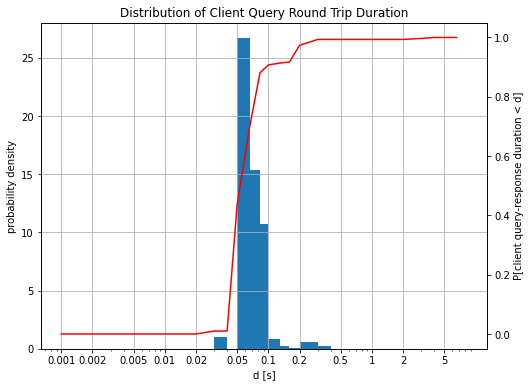

In [59]:
# client query duration distribution

queries['duration'] = queries['finished'] - queries['started']

data = queries['duration'].astype(np.float).dropna()
bins = [b*10**p for p in [-3, -2, -1, 0] for b in [1,1.3,1.6,2,3,4,5,6.6,8.3]]
labels = bins[::3]
hist, bin_edges = np.histogram(data, bins=bins)
cdf = np.cumsum(hist)

plt.figure(figsize=(8, 6))
plt.grid(True)

ax, tax = plt.gca(), plt.twinx()

ax.hist(data, bins=bins, density=True)
ax.set_ylabel('probability density')
ax.set_xlabel('d [s]')

tax.plot(bin_edges[:-1], cdf/cdf[-1], c='r')
tax.set_ylabel('P[client query-response duration < d]')

plt.xscale('log')
plt.xticks(labels, map(str, labels))
plt.title('Distribution of Client Query Round Trip Duration')

None